/var/folders/2f/rf_rskvj4vgbhssfn_h9q1s00000gn/T/ipykernel_16728/684173177.py:113: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to provide space for title


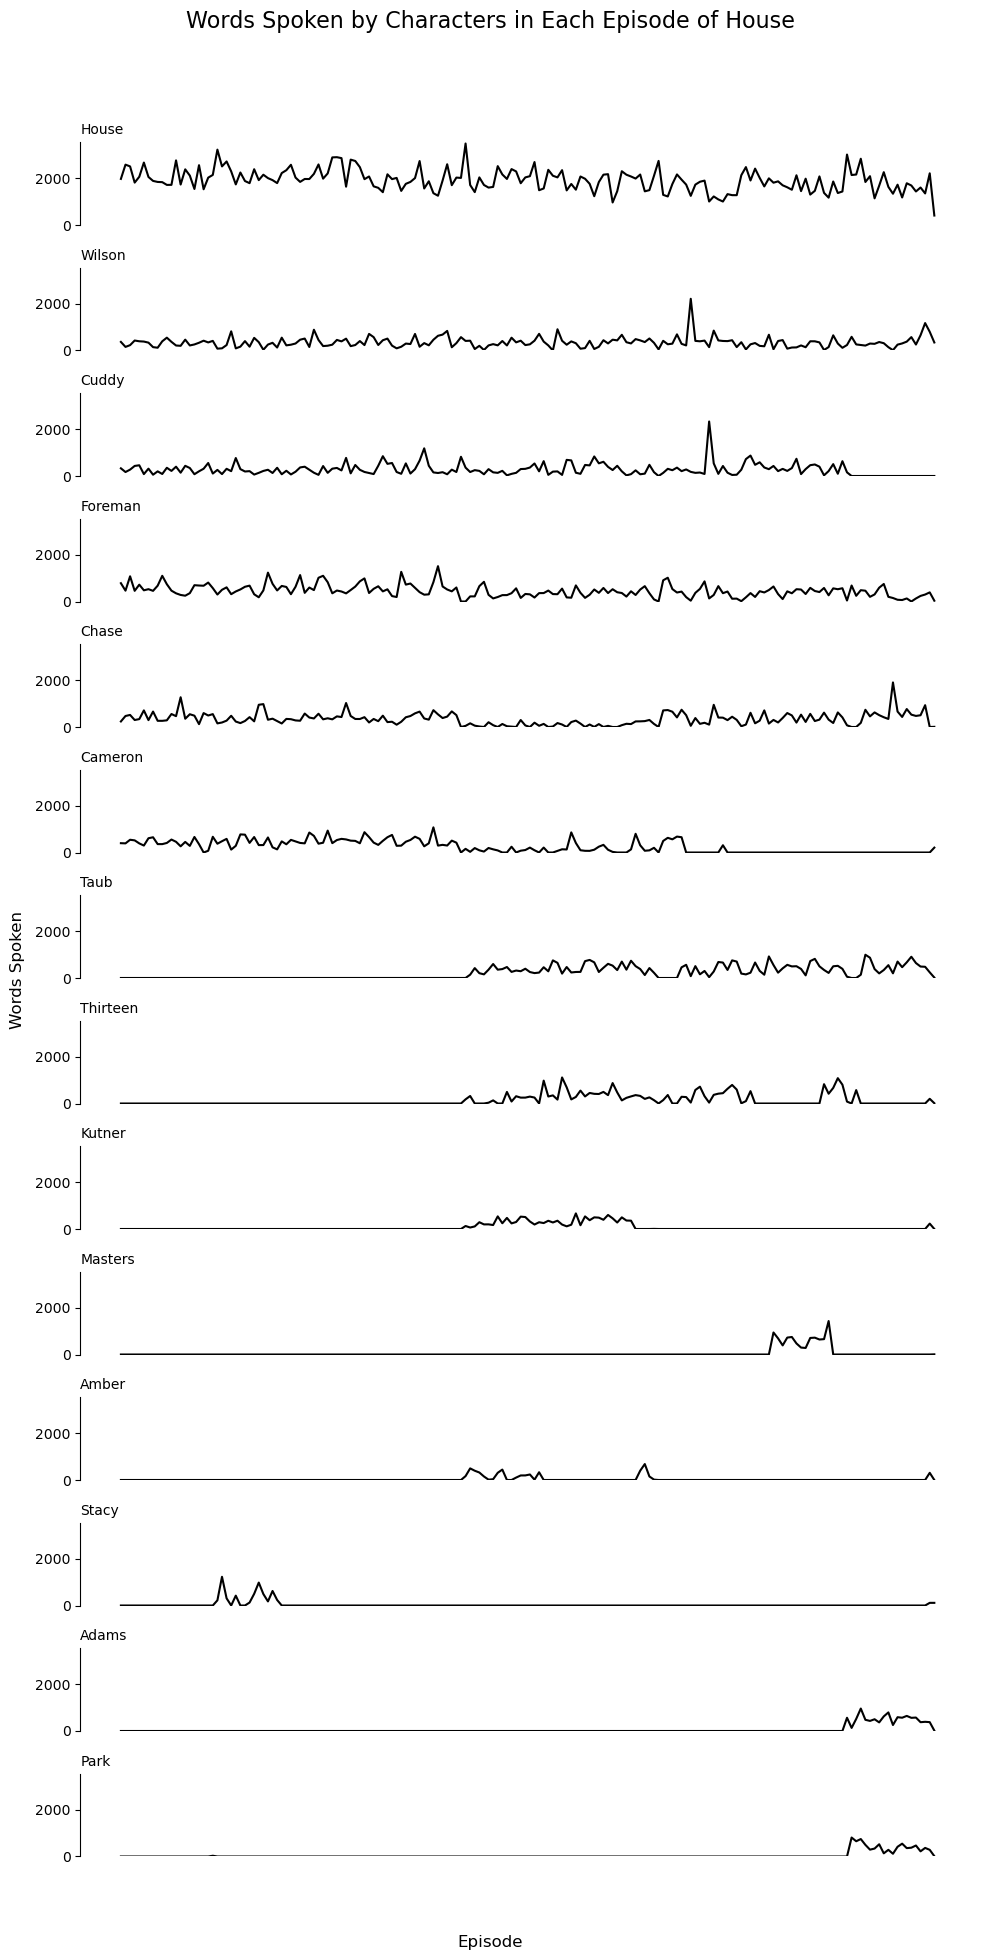

In [1]:
from collections import defaultdict
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt

# List of names to focus on
top_14_names = ['House', 'Wilson', 'Cuddy', 'Foreman', 'Chase', 'Cameron', 'Taub', 'Thirteen', 'Kutner', 'Masters', 'Amber', 'Stacy', 'Adams', 'Park']

# Total number of episodes across all seasons
total_episodes = 177

def consolidate_csv_files(output_filename, *input_filenames):
    with open(output_filename, 'w', newline='') as outfile:
        writer = None
        for filename in input_filenames:
            with open(filename, 'r') as infile:
                reader = csv.reader(infile)
                header = next(reader)
                if writer is None:
                    writer = csv.writer(outfile)
                    writer.writerow(header)  # Write the header only once
                for row in reader:
                    writer.writerow(row)

def process_file(filename, names):
    # Initialize the dictionary to hold word counts per episode per character
    episode_word_count = defaultdict(lambda: defaultdict(int))

    # Define regex patterns for names to handle variations
    name_patterns = {name: re.compile(r'\b' + re.escape(name) + r'(\s*\[.*?\])?', re.IGNORECASE) for name in names}

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header

        # Calculate the episode length
        total_rows = sum(1 for row in reader)
        file.seek(0)
        next(reader)  # Skip the header again after iterating through
        episode_length = total_rows // total_episodes

        current_episode = 1
        row_count = 0

        for row in reader:
            if row_count >= episode_length:
                current_episode += 1
                row_count = 0

            words = row[1].split()  # Get the words from 'line' which is the second column (index 1)
            name = row[0].strip()  # Get the name from 'name' which is the first column (index 0)

            # Match the name against the patterns to check if it's in our list
            for name_key, pattern in name_patterns.items():
                if pattern.match(name):
                    episode_word_count[f'ep{current_episode}'][name_key] += len(words)
                    break

            row_count += 1

        # If a name does not appear in the episode, add the name with a value of 0
        for episode in episode_word_count.values():
            for name in names:
                if name not in episode:
                    episode[name] = 0

    # Convert defaultdict to regular dict
    episode_word_count = {k: dict(v) for k, v in episode_word_count.items()}

    return episode_word_count

# Example usage
input_files = ['season1.csv', 'season2.csv', 'season3.csv', 'season4.csv', 'season5.csv', 'season6.csv', 'season7.csv', 'season8.csv']
output_file = 'consolidated.csv'

# Step 1: Consolidate CSV files
consolidate_csv_files(output_file, *input_files)

# Step 2: Process the consolidated file
episode_word_counts = process_file(output_file, top_14_names)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(episode_word_counts).T.fillna(0)

# Reorder the DataFrame columns to match top_14_names
df = df[top_14_names]

# Find the maximum word count for setting y-axis limit
max_word_count = df.max().max()

# Create a figure for the sparklines
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 20), sharex=True, constrained_layout=True)

# Plot each character in its own subplot
for idx, character in enumerate(df.columns):
    ax = axes[idx]
    ax.plot(df.index, df[character], linestyle='-', color='black')
    ax.set_title(character, fontsize=10, loc='left')
    ax.set_ylim(0, max_word_count + 50)  # Set the same y-limits for all
    ax.tick_params(left=True, labelleft=True, bottom=False, labelbottom=False)  # Show y-axis ticks and labels
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)

# Common labels
fig.suptitle('Words Spoken by Characters in Each Episode of House', fontsize=16)
fig.supxlabel('Episode', fontsize=12)
fig.supylabel('Words Spoken', fontsize=12)

# Apply tight layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to provide space for title
plt.savefig('wordCount.png')
plt.show()
